## Fine Tuning of VGG16 for Biofuel Material Cassification

In [1]:
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras as kr

%matplotlib inline

In [2]:
DATASET_ROOT = './dataset/'
TRAIN_FOLDER = 'train'
VALIDATION_FOLDER = 'validation'
TEST_FOLDER = 'test'

In [3]:
#=========[IMAGE PREPERATION]
IDG = kr.preprocessing.image.ImageDataGenerator
TR_IDG = IDG(rescale=1)
VA_IDG = IDG(rescale=1)
TE_IDG = IDG(rescale=1)

# Generator for training data set
train_set = TR_IDG.flow_from_directory(
    DATASET_ROOT + TRAIN_FOLDER, 
    target_size=(224,224), 
    batch_size=10
);

# Generator for validation data set
validation_set = VA_IDG.flow_from_directory(
    DATASET_ROOT + VALIDATION_FOLDER, 
    target_size=(244,244), 
    batch_size=10
);

# Generator for test data set
test_set = TE_IDG.flow_from_directory(
    DATASET_ROOT + TEST_FOLDER, 
    target_size=(224,224), 
    batch_size=10
);

Found 2411 images belonging to 2 classes.
Found 917 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


C:\Users\Robin\Anaconda3\envs\COMP591\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


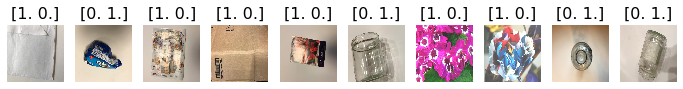

In [4]:
# Tool to display data set and its labels
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
	if type(ims[0]) is np.ndarray:
		ims = np.array(ims).astype(np.uint8)
		if (ims.shape[-1] != 3):
			ims = ims.transpose((0,2,3,1))
	f = plt.figure(figsize=figsize)
	cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
	for i in range(len(ims)):
		sp = f.add_subplot(rows, cols, i+1)
		sp.axis('Off')
		if titles is not None:
			sp.set_title(titles[i], fontsize=16)
		plt.imshow(ims[i], interpolation=None if interp else 'none')

# next() gets batches of size batch_size
imgs, labels = next(train_set)
plots(imgs, titles=labels)

In [5]:
#========[FETCHING STAGE] - Fetch VGG16 model from keras
vgg16 = kr.applications.vgg16
vgg16_model = vgg16.VGG16(include_top=True, weights='imagenet')

In [6]:
#========[BUILD STAGE] - We need our last layer to be a binary output, so we edit VGG16

# Freeze all the layers
for layer in vgg16_model.layers[:]:
    layer.trainable = False

# Create the model
model = kr.models.Sequential()

# Add the vgg convolutional base model
model.add(vgg16_model)

# easy
Dropout, Flatten, Dense = kr.layers.Dropout, kr.layers.Flatten, kr.layers.Dense

# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1000)              138357544 
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1025024   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 139,384,618
Trainable params: 1,027,074
Non-trainable params: 138,357,544
_________________________________________________________________


In [ ]:
#========[TRAIN STAGE] -
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=kr.optimizers.RMSprop(lr=1e-4),
    metrics=['acc']
)

# Train the Model
history = model.fit_generator(
      train_set,
      steps_per_epoch=train_set.samples/train_set.batch_size,
      epochs=20,
      validation_data=validation_set,
      validation_steps=validation_set.samples/validation_set.batch_size,
      verbose=1
)

Epoch 1/20
 48/241 [====>.........................] - ETA: 46:26 - loss: 0.6818 - acc: 0.6396

### Cells Below Are for Testing Purposes

In [ ]:
####### DONT RUN - THIS IS THE CELL FOR OUTPUT TESTING ########
train_set[0][0][0][0][0]

In [ ]:
####### DONT RUN - THIS IS FOR TESTING PURPOSES ########

# load the model
vgg16 = kr.applications.vgg16
model = vgg16.VGG16()
# load an image from file
image = kr.preprocessing.image.load_img('dataset/train/biomass/cardboard189.jpg', target_size=(224, 224))
# convert the image pixels to a numpy array
image = kr.preprocessing.image.img_to_array(image)
# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# prepare the image for the VGG model
image = vgg16.preprocess_input(image)
# predict the probability across all output classes
yhat = model.predict(image)
# convert the probabilities to class labels
label = vgg16.decode_predictions(yhat)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
# print the classification
print('%s (%.2f%%)' % (label[1], label[2]*100))

In [ ]:
train_set[,:0]